## Polynomial Adjust

(With normalize data)

In [85]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt

In [86]:
# Change this path to run in your machine
home_path = 'C:/Users/54911/OneDrive/Documentos/git_repos/elecciones2023-arg'

In [87]:
os.chdir(home_path)

In [88]:
def pasar_a_datetime(fecha):
    #format_string = '%Y-%m-%d'
    anio,mes,dia= fecha.split('-')
    aux_dia = dia.split(' ')
    if len(aux_dia)>1:dia = aux_dia[0]
    res = datetime(int(anio),int(mes),int(dia))
    return res

In [89]:
primera_vuelta = pd.read_csv('Elecciones + IA/getting_data/surveys/data_scraped/normalize_primera_vuelta.csv')
ballotage = pd.read_csv('Elecciones + IA/getting_data/surveys/data_scraped/normalize_ballotage.csv')

In [90]:
parties_primera_vuelta = primera_vuelta.columns[0:5]
parties_ballotage = ballotage.columns[0:2]

In [91]:
primera_vuelta['Inicio'] = primera_vuelta['Inicio'].map(lambda x:pasar_a_datetime(x))
primera_vuelta['Final'] = primera_vuelta['Final'].map(lambda x:pasar_a_datetime(x))
ballotage['Inicio'] = ballotage['Inicio'].map(lambda x:pasar_a_datetime(x))
ballotage['Final'] = ballotage['Final'].map(lambda x:pasar_a_datetime(x))

For duplicates date I group the data by the mean values

In [92]:
primera_vuelta_clean_grouped = primera_vuelta.groupby(by=['Inicio','Final'])[parties_primera_vuelta].mean().reset_index()
ballojate_clean_grouped = ballotage.groupby(by=['Inicio','Final'])[parties_ballotage].mean().reset_index()

## Let's find the best degree

In [93]:
def trainModel(data,party,degrees):
    X = np.arange(len(data))
    y = data[party]
    X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y, test_size=0.2, random_state=42)

    train_scores = []
    test_scores = []
    # Define a pipeline including PolynomialFeatures and LinearRegression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures()),
        ('regression', LinearRegression())
    ])
    # Define parameter grid for PolynomialFeatures degree
    param_grid = {
        'poly__degree': degrees
    }
    degrees = param_grid['poly__degree']
    for degree in degrees:
        pipeline.set_params(poly__degree=degree)
        pipeline.fit(X_train, y_train)
        train_score = -mean_squared_error(y_train, pipeline.predict(X_train))
        test_score = -mean_squared_error(y_test, pipeline.predict(X_test))
        train_scores.append(train_score)
        test_scores.append(test_score)

    # Plot degree vs. training and testing scores
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_scores, label='Training Score', marker='o')
    plt.plot(degrees, test_scores, label='Testing Score', marker='o')
    plt.xlabel('Degree')
    plt.ylabel('Negative Mean Squared Error')
    plt.title('Degree vs. Training/Testing Score')
    plt.xticks(degrees)
    plt.legend()
    plt.grid(True)

In [94]:
degrees_candidates=[1, 2, 3, 4, 5,6,7,8]

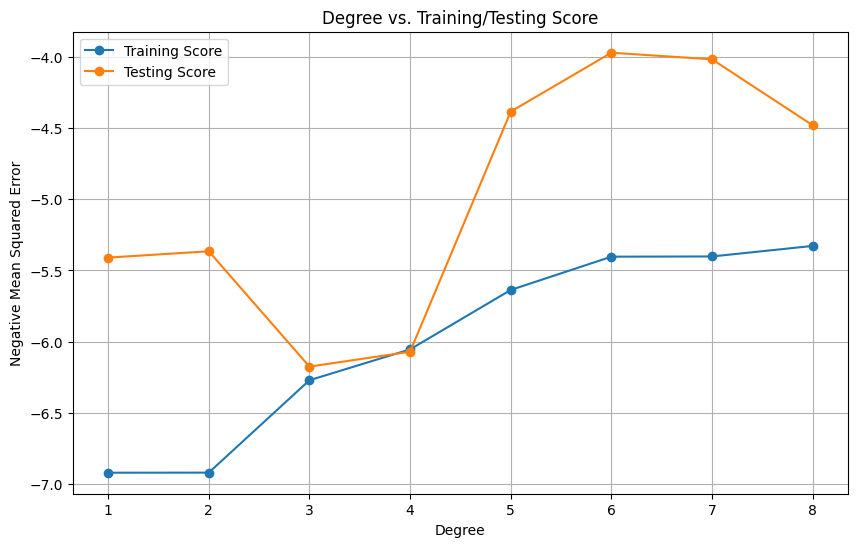

In [95]:
trainModel(primera_vuelta_clean_grouped,parties_primera_vuelta[0],degrees_candidates)

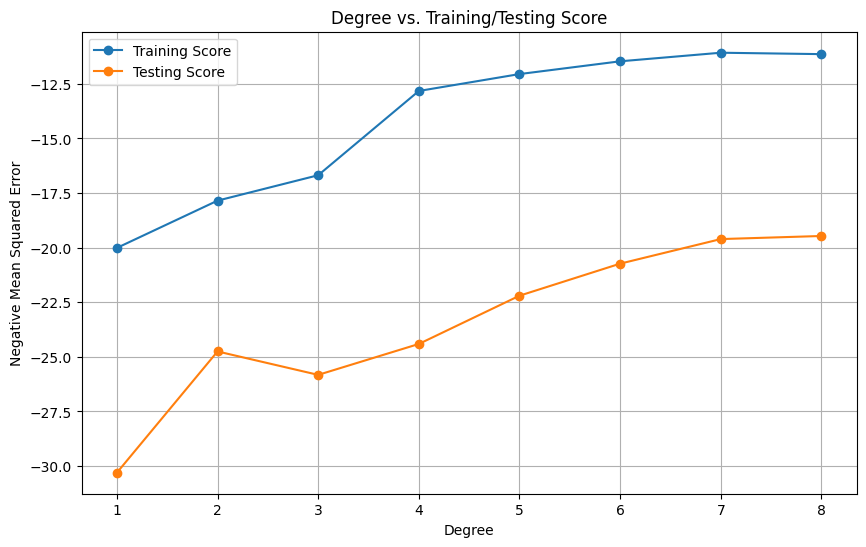

In [96]:
trainModel(primera_vuelta_clean_grouped,parties_primera_vuelta[1],degrees_candidates)

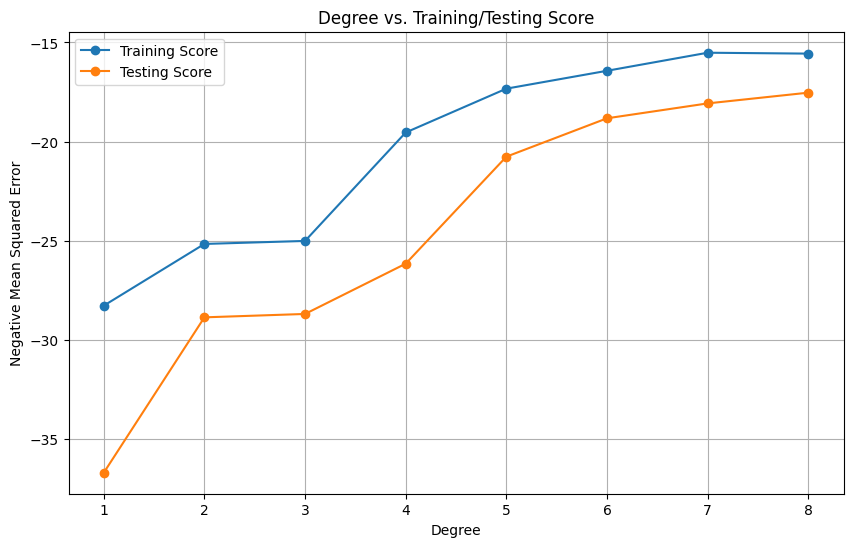

In [97]:
trainModel(primera_vuelta_clean_grouped,parties_primera_vuelta[2],degrees_candidates)

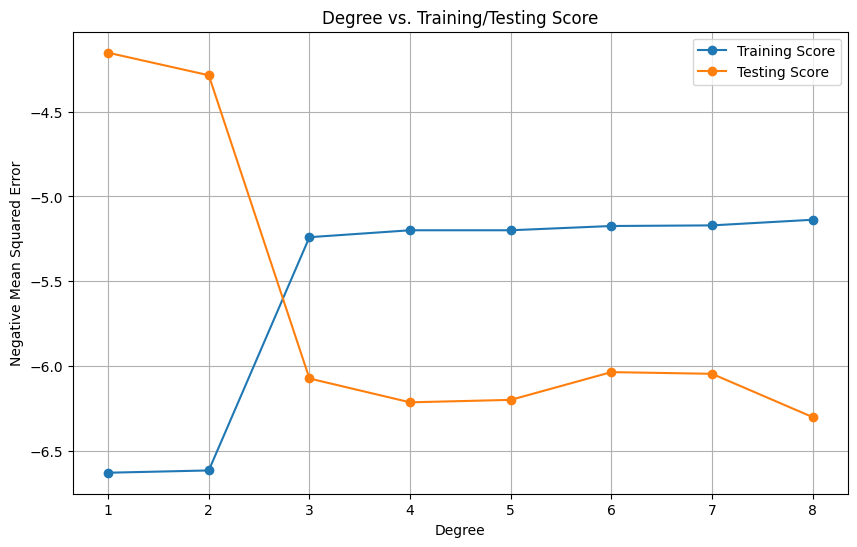

In [98]:
trainModel(primera_vuelta_clean_grouped,parties_primera_vuelta[3],degrees_candidates)

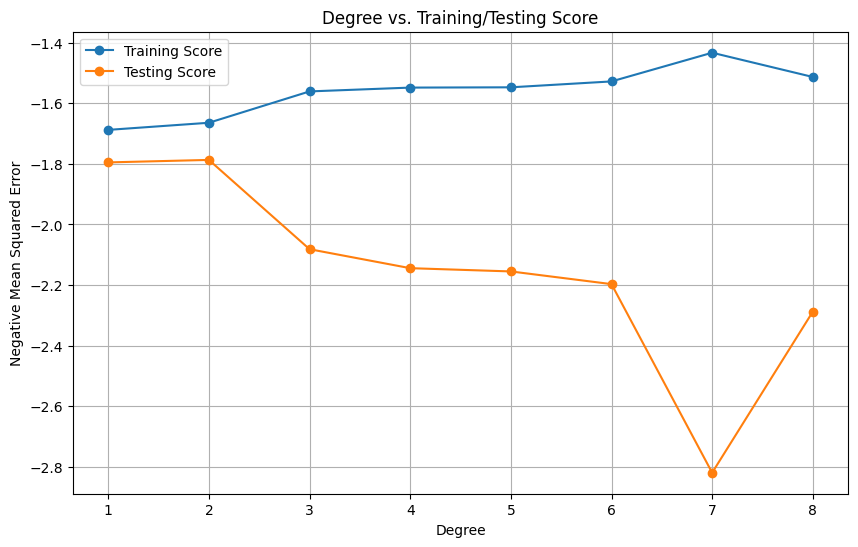

In [99]:
trainModel(primera_vuelta_clean_grouped,parties_primera_vuelta[4],degrees_candidates)

It seems that work better with degree = 6 the  first party, 

then degree=8 the 2 next ones ,and the 2 last ones work fine with degree=2

Text(0, 0.5, 'Percentage')

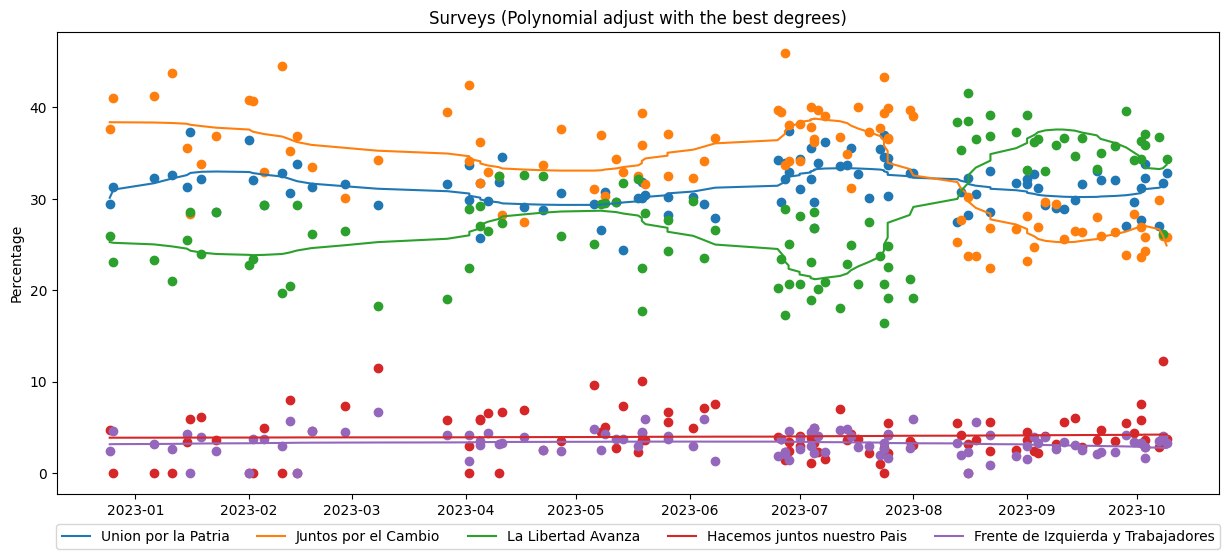

In [100]:
degrees = [6,8,8,2,2]
axis_x = np.arange(len(primera_vuelta_clean_grouped))
plt.figure(figsize=(15,6))

#maybe is better to add subplots
dates = primera_vuelta_clean_grouped['Inicio']
for i,party in enumerate(parties_primera_vuelta):
    
    poly_reg_model = LinearRegression()
    poly = PolynomialFeatures(degree=degrees[i], include_bias=False)
    poly_features = poly.fit_transform(axis_x.reshape(-1, 1))
    
    y = primera_vuelta_clean_grouped[party].to_numpy()
    poly_reg_model.fit(poly_features, y)
    Y_=poly_reg_model.predict(poly_features)
   
    plt.plot(dates, Y_,label=party)
    plt.scatter(dates,primera_vuelta_clean_grouped[party])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=5)
plt.title('Surveys (Polynomial adjust with the best degrees)')
plt.ylabel('Percentage')

## Ballotage

In [101]:
degrees_candidates=[1,2,3,4,5]

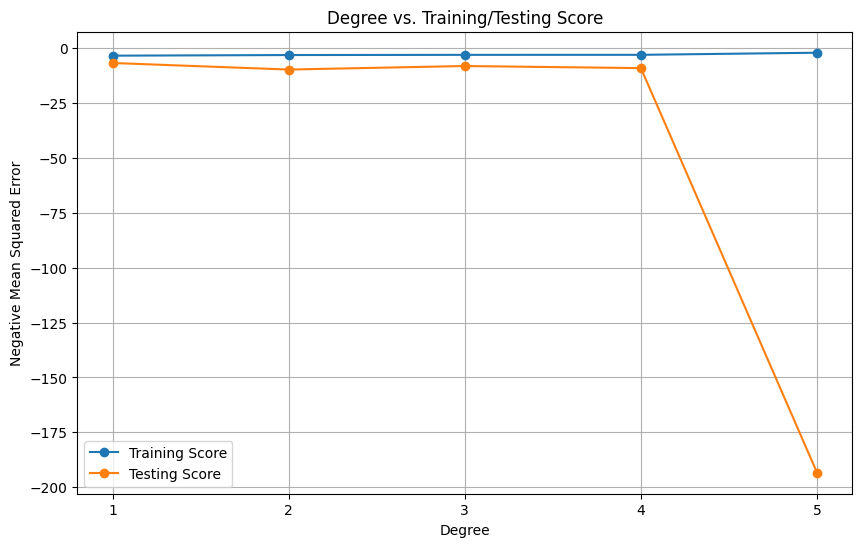

In [102]:
trainModel(ballojate_clean_grouped,parties_ballotage[0],degrees_candidates)

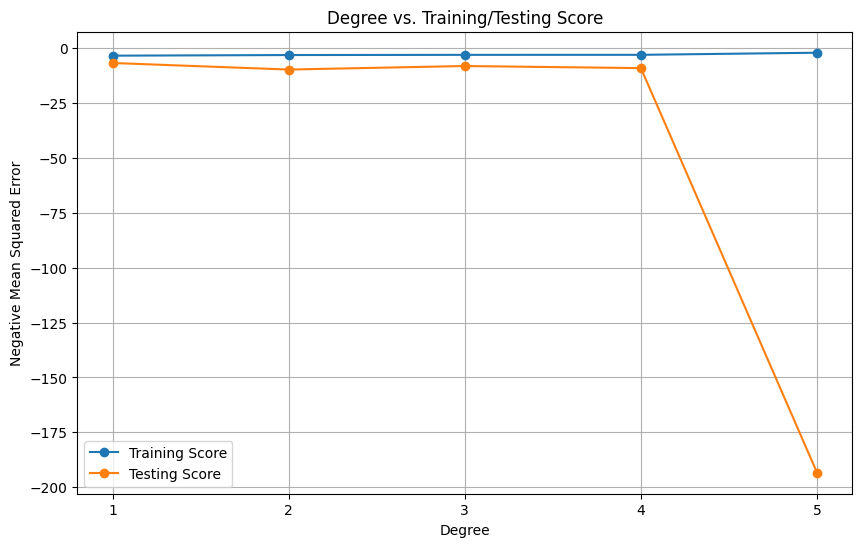

In [103]:
trainModel(ballojate_clean_grouped,parties_ballotage[1],degrees_candidates)

The best params for both parties are degree equals 4

Text(0, 0.5, 'Percentage')

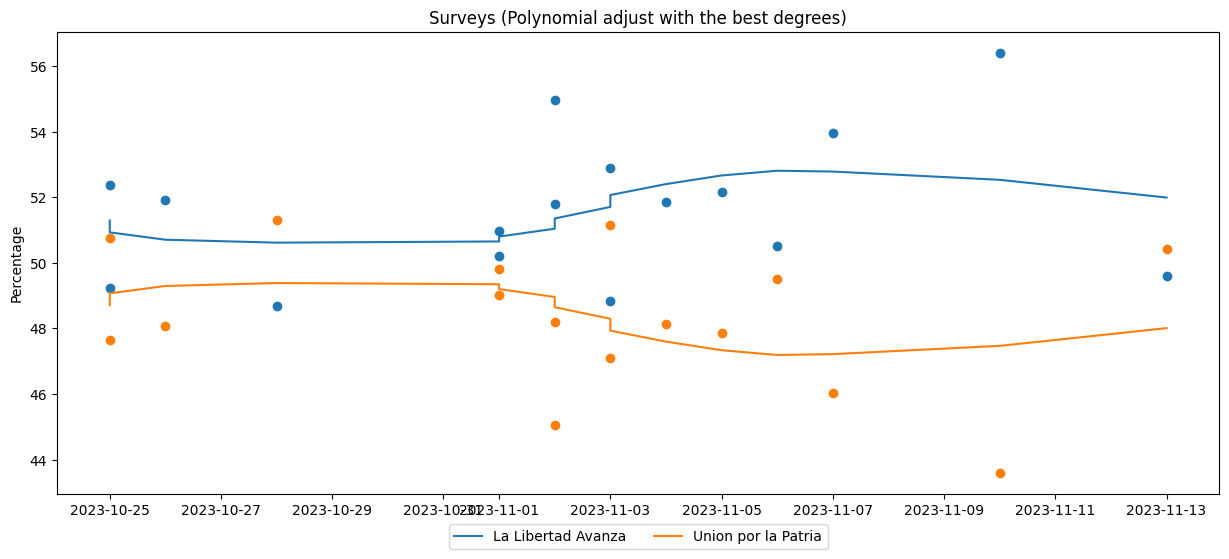

In [104]:
degrees = [4,4]
axis_x = np.arange(len(ballojate_clean_grouped))
plt.figure(figsize=(15,6))

#maybe is better to add subplots
dates = ballojate_clean_grouped['Inicio']
for i,party in enumerate(parties_ballotage):
    
    poly_reg_model = LinearRegression()
    poly = PolynomialFeatures(degree=degrees[i], include_bias=False)
    poly_features = poly.fit_transform(axis_x.reshape(-1, 1))
    
    y = ballojate_clean_grouped[party].to_numpy()
    poly_reg_model.fit(poly_features, y)
    Y_=poly_reg_model.predict(poly_features)
    
    plt.plot(dates, Y_,label=party)
    plt.scatter(dates,ballojate_clean_grouped[party])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=5)
plt.title('Surveys (Polynomial adjust with the best degrees)')
plt.ylabel('Percentage')